# Kalman Filter Models
> Models that use Kalman filters that can be used for imputation and learn parameters with gradient descend

In [ ]:
%load_ext autoreload
%autoreload 2

## Introduction

[TODO] add proper introduction here

The models uses a latent state variable $x$ that is modelled over time, to impute gaps in $y$

### Equations

The equations of the model are:

$$\begin{align} p(x_t | x_{t-1}) & = \mathcal{N}(x_t, Ax_{t-1}, Q) \\
p(y_t | x_t) & = \mathcal{N}(Hx_t, T) \end{align}$$

The Kalman filter has 3 steps:

- filter (updating the state at time t with observations till time t-1)
- update (update the state at time t using the observation at time t)
- smooth (update the state using the observations at time t+1)

In case of missing data the update step is skipped.

After smoothing the whole dataset the missing data ($y_t$) can be imputed from the state ($x_t$) using this formula:
$$p(y_t) = \mathcal{N}(Hx_x, R + HP^s_tH)$$

## Kalman Filter Model


In [ ]:
#| hide
#| default_exp kalman.model

In [ ]:
#| export
import pandas as pd
from fastcore.basics import store_attr

import numpy as np
from fastcore.meta import delegates
from fastcore.basics import patch

from meteo_imp.results import ImputationResult, _plot_error_bar
from meteo_imp.utils import *
from meteo_imp.kalman.filter import KalmanFilter

from torch import Tensor
import torch
from tqdm.auto import tqdm
import altair as alt

In [ ]:
#| export
class KalmanModel():
    """Kalman Model wtih max likelihood and gradient descend to optimize paramters and support for missing observations"""
    _var_names = None
    def __init__(self,
                 data: Tensor, # array of observations containg `NaN` for missing obs
                 **kwargs):
        self.data = data
        self.n_obs = data.shape[0]
        self.n_features = data.shape[1]
        
        kwargs = {**kwargs,
               'n_dim_state': self.n_features,
                'n_dim_obs': self.n_features
               }
        
        self.filter = KalmanFilter(**kwargs)
    
    def train(self,  
              times: Tensor|None, # for loss function times
              obs_test: Tensor|None, # for loss function observations
              n_iter: int=20,
              lr=0.1,
             ):
        "fit parameters by maximizing log likelihood using gradient descent"
        self.filter.train() # set training model for model
        
        if times is None and obs_test is None:
            times = torch.arange(self.n_obs)
            obs_test = self.data
        
        # Use the adam optimizer
        optimizer = torch.optim.Adam(self.filter.parameters(), lr=lr) 
        
        if not hasattr(self, 'losses'):
            self.losses = torch.zeros(n_iter)
            self.model_infos = [None for _ in range(n_iter)]
            offset = 0
        else:
            self.losses = torch.concat([self.losses, torch.zeros(n_iter)])
            self.model_infos.extend([None for _ in range(n_iter)])
            offset = self.losses.shape[0]
        
        for i in tqdm(range(n_iter)):
            optimizer.zero_grad()
            # Output from model
            # Calc loss and backprop gradients
            loss = -self.filter.loglikelihood(self.data, times, obs_test)
            self.losses[i + offset] = loss.detach()
            loss.backward()
            
            self.model_infos[i + offset] = self.filter.get_info(self.var_names)

            optimizer.step()
        
        
        # mean, cov = self.filter.smooth(self.data) 
        # self.state = ListNormal(mean, cov)
        return self
    
    @torch.no_grad()
    def predict(self, t):
        return self.filter.predict(self.data, t).detach()
    
    @property
    def latent_names(self):
        return [f"z_{i}" for i in range(self.filter.transition_matrices.shape[0])]
    @property
    def var_names(self):
        return self._var_names if self._var_names is not None else [f"x_{i}" for i in range(self.n_features)]
    
    @var_names.setter
    def var_names(self, var_names):
        self._var_names = var_names
    

In [ ]:
X = torch.arange(6).unsqueeze(0).T

In [ ]:
X

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5]])

In [ ]:
X.shape

torch.Size([6, 1])

In [ ]:
k = KalmanModel(X)

In [ ]:
k.train(None, None, n_iter = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

<__main__.KalmanModel>

In [ ]:
import matplotlib.pyplot as plt

[<matplotlib.lines.Line2D>]

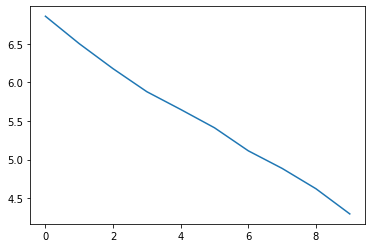

In [ ]:
plt.plot(k.losses)

In [ ]:
T = torch.arange(1,X.shape[0])

In [ ]:
T

tensor([1, 2, 3, 4, 5])

In [ ]:
k.predict(T)

ListNormal(mean=tensor([[1.0892],
        [1.9796],
        [2.9386],
        [4.0071],
        [5.2515]], grad_fn=<CopySlices>), cov=tensor([[[0.5605]],

        [[0.5763]],

        [[0.5945]],

        [[0.6328]],

        [[0.7286]]], grad_fn=<CopySlices>))

### State

In [ ]:
#| export
def _cov2std(x):
    "convert cov of array of covariances to array of stddev"
    return torch.diagonal(torch.sqrt(x), dim1=1, dim2=2)

In [ ]:
#| export
@patch
def plot_state(self: KalmanModel, n_cols = 2, bind_interaction = True, properties={}):

    s_mean, s_cov = self.state
    s_std = _cov2std(s_cov)
    
    time = torch.arange(self.n_obs)
    
    mean = array2df(s_mean, time, self.latent_names, 'time').melt('time', value_name='mean')
    std = array2df(s_std, time, self.latent_names, 'time').melt('time', value_name='std' )
    
    state = pd.merge(mean, std, on=['time', 'variable'])
    
    plot_list = [alt.hconcat() for _ in range(0, len(self.latent_names), n_cols)]
    selection_scale = alt.selection_interval(bind="scales", encodings=['x']) if bind_interaction else None
    for idx, variable in enumerate(self.latent_names):
        data = state[state.variable == variable]
        plot_list[idx // n_cols] |= _plot_error_bar(data,
                                                   variable,
                                                   y_label = variable,
                                                   sel = selection_scale, properties=properties)
    
    plot = alt.vconcat(*plot_list)
    
    return plot


In [ ]:
# k.plot_state()

### Plot Loss

In [ ]:
#| export
@patch
def plot_loss(self: KalmanModel, size={'width': 250, 'height': 120}):
    
    sel = alt.selection_interval(bind="scales", encodings=['x'])
    
    plt_losses = alt.Chart(
        pd.DataFrame({'loss': self.losses, 'n_iter': range(self.losses.shape[0])})
    ).mark_line().encode(
        x = 'n_iter',
        y = alt.Y('loss', scale=alt.Scale(zero=False))
    ).properties(title="loss", **size).add_selection(sel)
    
    return plt_losses

In [ ]:
k.plot_loss()

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

## Export 

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()